# Flower Classification with VGG16
### Author: Salma OUARDI
Dataset: [Flowers Recognition](https://www.kaggle.com/datasets/alxmamaev/flowers-recognition)

### On import la base de données depuis Kaggle

In [146]:
# reset data dir
import os,sys

PROJ_DIR='/home/logic/_wsl_workspace/google-colab-playlist/kaggle/ML_vinniesniper-54816'

STORE_DIR=os.path.join(PROJ_DIR, '00_store')
DATA_DIR=os.path.join(PROJ_DIR, '01_data')
TMP_DIR=os.path.join(PROJ_DIR, '02_tmp')
MODEL_DIR=os.path.join(PROJ_DIR, '03_model')

# !rm -rf {PROJ_DIR}/data/*
!rm -rf {DATA_DIR}/*

!mkdir -p {DATA_DIR}

!mkdir -p {DATA_DIR}/test
!mkdir -p {DATA_DIR}/train
!mkdir -p {DATA_DIR}/valid

DATA_TRAIN_DIR=DATA_DIR+"/train"
DATA_VALID_DIR=DATA_DIR+"/valid"
DATA_TEST_DIR=DATA_DIR+"/test"

# environment 

# originally 240,240
# size=(150,150)
image_w = 150
image_h = 150


In [150]:
!cp -r /kaggle/input/custom-data/custom_image/*  {STORE_DIR}
!cp -r /kaggle/input/ml-vinniesniper-54816-test/* {DATA_DIR}/test


^C


In [148]:
%pip install kaggle
%pip install pandas
%pip install seaborn
%pip install scipy
%pip install pickle

import os
import shutil
from os.path import isfile, join, abspath, exists, isdir, expanduser
from os import listdir, makedirs, getcwd, remove
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import matplotlib.image as mimg

import tensorflow as tf
print(tf.__version__)
# tensorflow 2.16 allows 
# from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array

from keras.utils import load_img, img_to_array
from keras import optimizers

from keras import layers
from keras import models
from keras import optimizers

import pickle
import json


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: python -m pip in

In [157]:
# Each species of flower is contained in a separate folder. Get all the sub directories
image_types = os.listdir(STORE_DIR)
print("Types of images found: ", len(image_types))
print("Categories of images: ", image_types)

Types of images found:  9
Categories of images:  ['horse', 'man', 'beach', 'bus', 'building', 'flower', 'elephant', 'mountain', 'dinosaur']


In [158]:
import os

num_skipped = 0
for folder_name in image_types:
    folder_path = os.path.join(STORE_DIR, folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1 images.


In [159]:
# A list that is going to contain tuples: (species of the flower, corresponding image path)
ds_images = []

for species in image_types:
    # Get all the file names
    all_flowers = os.listdir(STORE_DIR +"/"+ species)
    # Add them to the list
    for flower in all_flowers:
        ds_images.append((species, str(STORE_DIR +"/"+species) + '/' + flower))

# Build a dataframe        
ds_images = pd.DataFrame(data=ds_images, columns=['category', 'image'], index=None)
ds_images.head()


,category,image
0,horse,/home/logic/_wsl_workspace/google-colab-playli...
1,horse,/home/logic/_wsl_workspace/google-colab-playli...
2,horse,/home/logic/_wsl_workspace/google-colab-playli...
3,horse,/home/logic/_wsl_workspace/google-colab-playli...
4,horse,/home/logic/_wsl_workspace/google-colab-playli...


In [160]:
# Let's check how many samples for each category are present
print("Total number of images in the dataset: ", len(ds_images))
ds_image_count = ds_images['category'].value_counts()
print("images in each category: ")
print(ds_image_count)

Total number of images in the dataset:  27629
images in each category: 
category
beach       4496
horse       4180
bus         4024
elephant    3858
flower      3711
mountain    3598
building    3372
dinosaur     201
man          189
Name: count, dtype: int64


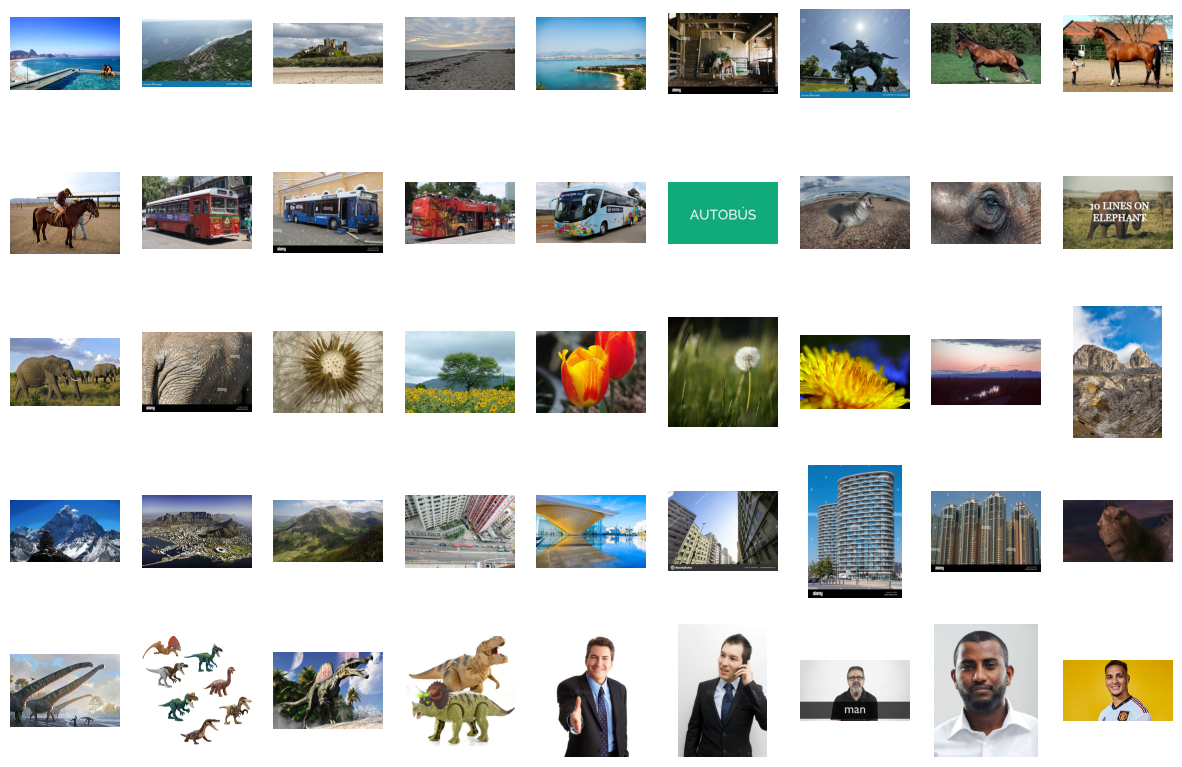

In [161]:
# Let's visualize some flowers from each category

# A list for storing names of some random samples from each category
random_samples = []

# Get samples fom each category 
for category in ds_image_count.index:
    samples = ds_images['image'][ds_images['category'] == category].sample(5).values
    for sample in samples:
        random_samples.append(sample)

# # Plot the samples
f, ax = plt.subplots(5,9, figsize=(15,10))
for i,sample in enumerate(random_samples):
    ax[i//9,i%9].imshow(mimg.imread(random_samples[i]))
    ax[i//9,i%9].axis('off')
plt.show()    


In [162]:
for type in image_types:
    %mkdir -p {DATA_TRAIN_DIR}/{type}
    %mkdir -p {DATA_VALID_DIR}/{type}

In [163]:
for category in ds_image_count.index:
    samples = ds_images['image'][ds_images['category'] == category].values
    #perm = np.random.permutation(samples)
    # Copy first 100 samples to the validation directory and rest to the train directory
    
    for i in range(100):
        name = samples[i].split('/')[-1]
        shutil.move(samples[i],DATA_VALID_DIR+'/' + str(category) + '/'+ name)

    for i in range(100,len(samples)):
        name = samples[i].split('/')[-1]
        shutil.move(samples[i],DATA_TRAIN_DIR+'/' + str(category) + '/' + name)

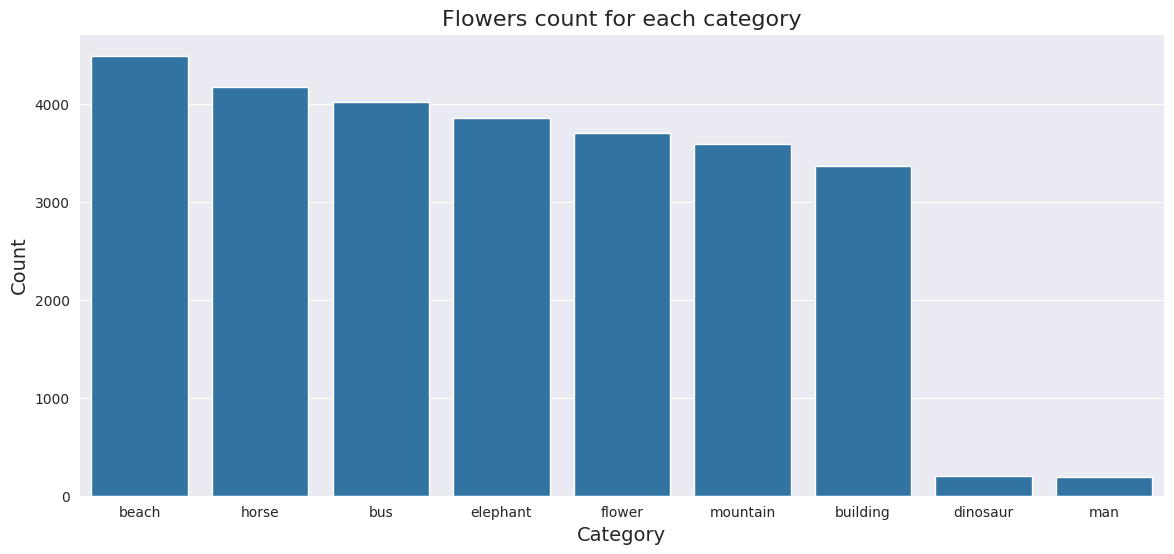

In [ ]:
# Let's do some visualization and see how many samples we have for each category

f, axe = plt.subplots(1,1,figsize=(14,6))
sns.barplot(x = ds_image_count.index, y = ds_image_count.values, ax = axe)
axe.set_title("Images count for each category", fontsize=16)
axe.set_xlabel('Category', fontsize=14)
axe.set_ylabel('Count', fontsize=14)
plt.show()

In [ ]:
from tensorflow.keras.applications import VGG16
conv_base = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(image_w, image_h, 3)
)

conv_base.summary()

## Feature Extraction

In [167]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(len(image_types), activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 9)                

In [168]:
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        DATA_TRAIN_DIR,
        target_size=(image_w, image_h),  # all images will be resized to 150x150
        batch_size=batch_size,
        class_mode='categorical'  # more than two classes
)

validation_generator = test_datagen.flow_from_directory(
        DATA_VALID_DIR,
        target_size=(image_w, image_h),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)


test_generator = test_datagen.flow_from_directory(
        DATA_TEST_DIR,
        target_size=(image_w, image_h),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle = False
)

Found 26729 images belonging to 9 classes.
Found 900 images belonging to 9 classes.
Found 900 images belonging to 9 classes.


In [169]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['acc'])

In [170]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=0.0001),
    metrics=['acc'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               4194816   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 9)                

In [174]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_acc', 
    mode='max', patience=10,  
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=2,# originally 6 epochs
    validation_data=validation_generator,
    validation_steps=100,
    callbacks=[es]
    )

Epoch 1/2
10/10 [==============================] - ETA: 0s - loss: 0.3358 - acc: 0.2963

2024-11-22 10:34:04.557663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-22 10:34:04.629773: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-22 10:34:04.629812: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-22 10:34:04.629849: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17714 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-11-22 10:34:04.629865: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_f

10/10 [==============================] - 23s 2s/step - loss: 0.3358 - acc: 0.2963 - val_loss: 0.2912 - val_acc: 0.4844
Epoch 2/2
10/10 [==============================] - ETA: 0s - loss: 0.3182 - acc: 0.3469WARNING:tensorflow:Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: loss,acc


10/10 [==============================] - 7s 591ms/step - loss: 0.3182 - acc: 0.3469


In [175]:
model.save(MODEL_DIR+'/model.h5')

with open(MODEL_DIR+'/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history, file_pi)

with open(MODEL_DIR+'/model_architecture.json', 'w') as f:
    f.write(model.to_json())


INFO:tensorflow:Assets written to: ram://272d3fa7-ec44-4aff-be06-fcb490f5b7a5/assets


INFO:tensorflow:Assets written to: ram://272d3fa7-ec44-4aff-be06-fcb490f5b7a5/assets


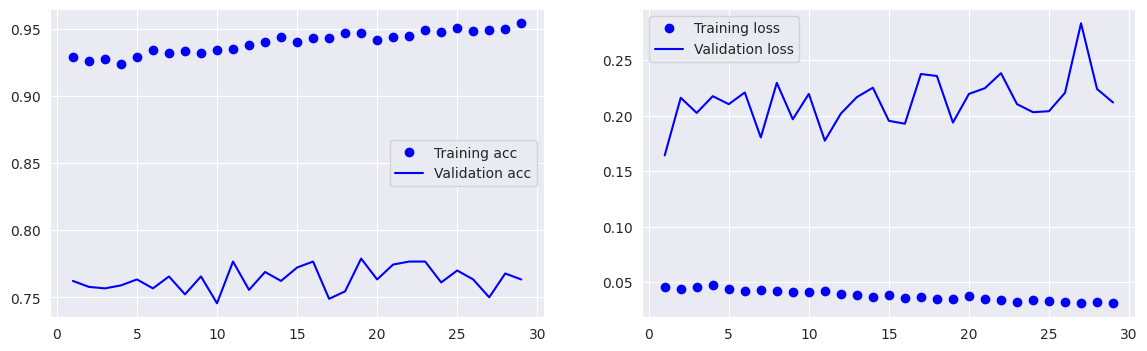

In [64]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

f, axes = plt.subplots(1,2,figsize=(14,4))

axes[0].plot(epochs, acc, 'bo', label='Training acc')
axes[0].plot(epochs, val_acc, 'b', label='Validation acc')
axes[0].legend()

axes[1].plot(epochs, loss, 'bo', label='Training loss')
axes[1].plot(epochs, val_loss, 'b', label='Validation loss')
axes[1].yaxis.set_label_position("right")
axes[1].legend()

plt.show()

In [65]:
model_3_val = val_acc[-1]
print("Validation Accuracy: ", model_3_val)

Validation Accuracy:  0.7633333802223206


In [66]:
def plot_confusion_matrix(cm, classes,                          normalize=False,                          title='Confusion matrix',                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(5,5))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

/tmp/ipykernel_485770/189939870.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = model.predict_generator(validation_generator)
2024-11-22 08:55:19.081106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-22 08:55:33.763586: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-22 08:55:33.763656: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 1, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-22 08:55:33.763741: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow dev

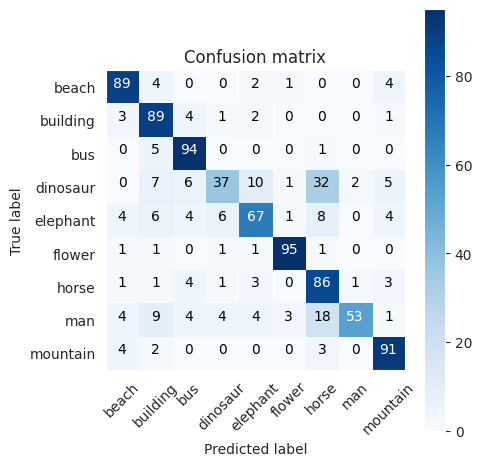

In [67]:
validation_generator.reset()
y_pred = model.predict_generator(validation_generator)
y_pred = y_pred.argmax(-1)
con_mat = tf.math.confusion_matrix(validation_generator.classes, y_pred)
con_mat = np.array(con_mat)
plot_confusion_matrix(cm = con_mat, classes = validation_generator.class_indices.keys(), normalize = False)

In [ ]:
!rm -rf /home/logic/.keras/datasets/Red_sunflower
# bus
sunflower_url = "https://images.unsplash.com/photo-1540457943340-2e70b692e50e"
# sunflower_url = "https://images.unsplash.com/photo-1590951360207-317cb18098b3"
# sunflower_url = "https://images.unsplash.com/photo-1491378630646-3440efa57c3b"
# sunflower_url = "https://images.unsplash.com/photo-1499190263783-18a53a561660"
sunflower_url = "https://images.unsplash.com/photo-1527576539890-dfa815648363"

# sunflower_url = "https://images.unsplash.com/photo-1544954412-78da2cfa1a0c"
# sunflower_url = "https://images.unsplash.com/photo-1550927049-d07581451e3c"
# sunflower_url = "https://images.unsplash.com/photo-1462216589242-9e3e00a47a48"
# sunflower_url = "https://images.unsplash.com/photo-1533523611631-15e4ef69be08"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

# train
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/daisy/144099102_bf63a41e4f_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/tulips/11746548_26b3256922_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/sunflowers/6953297_8576bf4ea3.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/train/tulips/17189526216_fa24dd541a_n.jpg"

# validation
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/daisy/144099102_bf63a41e4f_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/dandelion/10683189_bd6e371b97.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/roses/159079265_d77a9ac920_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/tulips/11746548_26b3256922_n.jpg"
# sunflower_path = "/home/logic/_wsl_workspace/google-colab-playlist/kaggle/data/valid/sunflowers/6953297_8576bf4ea3.jpg"

img = tf.keras.utils.load_img(    sunflower_path, target_size=(image_h, image_w))

img


In [ ]:
class_names = list(validation_generator.class_indices.keys())

import pandas as pd

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

data = np.array([class_names,predictions[0]])
print(pd.DataFrame(data))


### 85% Accuracy using VGG16.